<a href="https://colab.research.google.com/github/tommasomncttn/NLP-Disaster-Tweet-Detection/blob/main/model's%20notebook/AWD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.0 MB/s eta 0:00:00


[I 2023-03-23 11:42:08,882] A new study created in memory with name: no-name-8133785c-7501-48ee-ada4-ad5d13ea613f
<ipython-input-4-dc22a5d0f5c4>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.8)
<ipython-input-4-dc22a5d0f5c4>:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


epoch,train_loss,valid_loss,accuracy,time
0,0.634072,0.573413,0.743421,01:27


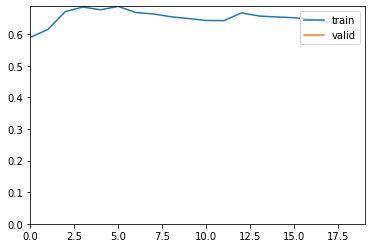

epoch,train_loss,valid_loss,accuracy,time
0,0.561312,0.593528,0.707237,03:36
1,0.535591,0.483894,0.792763,03:33
2,0.499265,0.482922,0.773026,03:29
3,0.464970,0.473854,0.782895,03:28


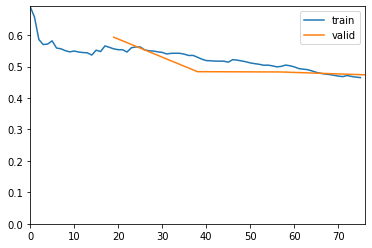

[I 2023-03-23 11:58:52,791] Trial 0 finished with value: -0.6923076923076923 and parameters: {'dropout': 0.40752365966033016, 'n_epochs': 4, 'learning_rate': 0.00507062535859564}. Best is trial 0 with value: -0.6923076923076923.


Best trial:
  Value: 0.69231
  Params: 
    dropout: 0.40752365966033016
    n_epochs: 4
    learning_rate: 0.00507062535859564


epoch,train_loss,valid_loss,accuracy,time
0,0.683806,0.574654,0.769737,01:26


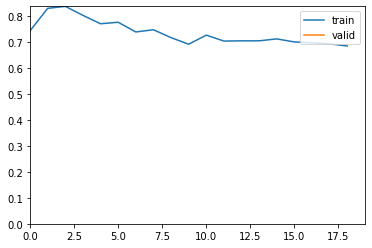

epoch,train_loss,valid_loss,accuracy,time
0,0.574341,0.466722,0.786184,03:29
1,0.541382,0.461721,0.789474,03:30
2,0.498406,0.459925,0.799342,03:32
3,0.466525,0.448005,0.809211,03:30


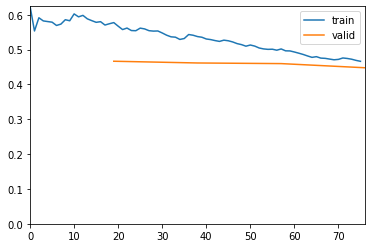

Test accuracy: 0.5738673806190491
Test f1 score: 0.8346839546191248


<ipython-input-4-dc22a5d0f5c4>:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_classes_tensor = torch.tensor(predicted_labels)


In [ ]:
# ===========================================
# ||                                       ||
# ||       Section 1: Importing modules    ||
# ||                                       ||
# ===========================================

from fastai.text.all import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import optuna

# ===========================================
# ||                                       ||
# ||       Section 2: getting dataframes   ||
# ||                    and dataloader     ||
# ||                                       ||
# ===========================================

#TODO use clean dataset
# Read in a CSV files

train_df = pd.read_csv("/content/drive/MyDrive/ML_proj/zaazazza/train_df.csv")
test_df = pd.read_csv("/content/drive/MyDrive/ML_proj/zaazazza/test_df.csv")
validation_df =  pd.read_csv("/content/drive/MyDrive/ML_proj/zaazazza/validation_df.csv")

# Drop not needed columns

train_df = test_df.drop(train_df.columns[0:4], axis=1)
validation_df = validation_df.drop(validation_df.columns[0:4], axis=1)
test_df = test_df.drop(test_df.columns[0:4], axis=1)

# Create a data loader for text data using the "TextDataLoaders" class from the fastai library.
dls = TextDataLoaders.from_df(train_df, valid_df=validation_df, path='.', valid_pct=0.2, seed=None,
                              text_col=0, label_col=1, label_delim=None,
                              y_block=None, text_vocab=None, is_lm=False,
                              valid_col=None, tok_tfm=None,
                              tok_text_col='text', seq_len=72)


In [ ]:

# ===========================================
# ||                                       ||
# ||       Section 3: hyperparameter       ||
# ||                        tuning         ||
# ||                                       ||
# ===========================================


def objective(trial):
    # Define the search space for hyperparameters
    dropout = trial.suggest_uniform('dropout', 0.2, 0.8)
    n_epochs = trial.suggest_int('n_epochs', 2, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Create a text classification learner with the suggested hyperparameters
    learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=dropout, metrics=accuracy)

    # Fine-tune the neural network for the suggested number of epochs using stochastic gradient descent
    learn.fine_tune(n_epochs, learning_rate, cbs=[ShowGraphCallback()])

    # Get the predicted probabilities for the validation data using the trained model.
    val_dl = dls.test_dl(validation_df['text'])
    val_preds, _ = learn.get_preds(dl=val_dl)

    # Get the predicted labels for the validation data.
    val_predicted_labels = val_preds.argmax(dim=1)

    # Compute the f1 score of the model on the validation data using the `f1_score` function.
    val_f1 = f1_score(validation_df["target"].values, val_predicted_labels)

    # Return the negative f1 score as the loss to optimize (because optuna maximizes the negative of the objective).
    return -val_f1

# Create an optuna study and optimize the objective function 
#(we are maximizing the f1 socore)
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

# Print the best set of hyperparameters found by optuna and the corresponding f1 score on the validation data.
print('Best trial:')
best_trial = study.best_trial
print(f'  Value: {-best_trial.value:.5f}')
print('  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Train the model with the best hyperparameters found by optuna and evaluate it on the test data.
best_dropout = best_trial.params['dropout']
best_n_epochs = best_trial.params['n_epochs']
best_learning_rate = best_trial.params['learning_rate']


In [ ]:
# ===========================================
# ||                                       ||
# ||       Section 4: train the model      ||
# ||                                       ||
# ===========================================

# Create a text classification learner using the fastai library.
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=best_dropout, metrics=accuracy)

# Fine-tune the neural network for four epochs using stochastic gradient descent
learn.fine_tune(best_n_epochs, best_learning_rate, cbs=[ShowGraphCallback()])


In [ ]:
# ===========================================
# ||                                       ||
# ||       Section 5: testing the model    ||
# ||                                       ||
# ===========================================

# Create a test dataloader from the test data using the `test_dl` method of the `dls` dataloaders object.
test_dl = dls.test_dl(test_df['text'])

# Get the predicted probabilities for the test data using the trained model.
preds, _ = learn.get_preds(dl=test_dl)

# Get the predicted labels for the test data.
predicted_labels = preds.argmax(dim=1)

# Convert the predicted labels to Python list and get the corresponding class names.
predicted_classes = [dls.vocab[i] for i in predicted_labels]

# Convert the predicted classes list to a tensor.
predicted_classes_tensor = torch.tensor(predicted_labels)

# Reshape the predicted tensor to have the same shape as the target tensor.
predicted_classes_tensor = predicted_classes_tensor.unsqueeze(1)

# Convert the target labels to a tensor.
target_tensor = torch.tensor(test_df["target"].values)

# Compute the accuracy and f1 score of the model on the test data using the `accuracy` and `f1_score` functions.
acc = accuracy(predicted_classes_tensor, target_tensor)
f1 = f1_score(target_tensor, predicted_classes_tensor)

# Print the accuracy and f1 score of the model on the test data.
print(f"Test accuracy: {acc}")
print(f"Test f1 score: {f1}")